# *SDS_Benchmark*: Assessment of the submitted shoreline time-series

The assessment is done for Landsat and using the Mean Sea Level as the reference contour.

When running this notebook you will compare all the submitted time-series, the plots showing the comparisons and reporting the accuracy metrics are saved under **/evaluation/MSL**. You can visualise each individual transect under **/evaluation/MSL/transects**

## Initial settings

To run this notebook you will need basic Python packages installed: `numpy`, `scipy`, `pandas`, `matplotlib`, `pytz`.

If you have [CoastSat](https://github.com/kvos/CoastSat) installed, you can activate that envrionment as it has all the necessary packages.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib import gridspec
import colorcet as cc
from matplotlib.cm import get_cmap
import pandas as pd
from datetime import datetime, timedelta
from scipy import interpolate
from scipy import stats
import pytz
import json
import pdb
import string
# import utils module located in the repository (utils.py)
import utils
plt.ion()
letters = string.ascii_lowercase

# filepaths to all the datasets
fp_datasets = os.path.join(os.path.join(os.getcwd(),'datasets'))
names_datasets = os.listdir(fp_datasets)
names_datasets = [_ for _ in names_datasets if _ not in ['README.md','sites_info.txt','CALAMILLOR']]
print('\nBenchmark datasets available:\n%s'%(names_datasets))
                
# load site info dict if exists or create
fp_info = os.path.join(fp_datasets,'sites_info.txt')
if os.path.exists(fp_info):
    with open(fp_info,'r') as f: sites_info = json.load(f)  
    print('\nLoaded sites_info.txt.')
    for key in sites_info.keys(): print('%s: %s'%(key,sites_info[key]))

# filepaths to submissions
fp_submissions = os.path.join(os.path.join(os.getcwd(),'submissions'))
submissions = [_ for _ in os.listdir(fp_submissions) if _ not in ['README.md','example_submission']]
print('\nSubmitted shorelines: %s'%submissions)

# folder where to save all the figures and outputs
fp_eval =  os.path.join(os.getcwd(),'evaluation')
if not os.path.exists(fp_eval): os.makedirs(fp_eval)


Benchmark datasets available:
['DUCK', 'NARRABEEN', 'TORREYPINES', 'TRUCVERT']

Loaded sites_info.txt.
NARRABEEN: {'beach_slope': 0.1, 'contour_level': 0.7, 'epsg': 28356}
DUCK: {'beach_slope': 0.1, 'contour_level': 0.585, 'epsg': 32119}
TRUCVERT: {'beach_slope': 0.05, 'contour_level': 1.5, 'epsg': 32630}
TORREYPINES: {'beach_slope': 0.045, 'contour_level': 0.792, 'epsg': 26946}
CALAMILLOR: {'beach_slope': 0.1, 'contour_level': 0, 'epsg': 2062}

Submitted shorelines: ['team_CASSIE', 'team_CoastSat', 'team_Deltares', 'team_SHOREX', 'team_UQMAO']


### Format submitted outputs

Read the submitted files and convert everything to a standard format that can be easily manipulated.

In [2]:
contour = 'MSL'
groundtruth_type = 'groundtruth_%s'%contour
# create a dictionnary with all the submitted time-series of shoreline change
sub_output = {}
# folder to store evaluation outputs
fp_eval_contour =  os.path.join(fp_eval,contour)
if not os.path.exists(fp_eval_contour): os.makedirs(fp_eval_contour)

# check if file already exists
fn_output = os.path.join(fp_eval_contour,'submissions_%s.pkl'%contour)

if os.path.exists(fn_output):
    # load submissions
    with open(fn_output,'rb') as f:
        sub_output = pickle.load(f)    
    print('Loaded formatted dict...') 
else:
    # loop through submissions
    for sub in submissions:
        print('\n'+sub)
        # get filepaths
        submission_folder = os.path.join(fp_submissions,sub)
        submission_sites = os.listdir(submission_folder)
        sub_output[sub] = {}
        # loop through sites
        for sitename in names_datasets:
            # skip site if it wasn't mapped
            if sitename not in submission_sites: continue
            sub_output[sub][sitename] = {}
            # locate submitted time-series
            if sub == 'team_Deltares':
                fp_timeseries = os.path.join(submission_folder,sitename,'Transect_Mapping','CSV','Monthly','raw_timeseries')
                date_str = 'Date'
                chain_str = 'Distance'
            elif sub == 'team_UQMAO':
                fp_timeseries = os.path.join(submission_folder,sitename)
                date_str = 'Date'
                chain_str = 'Distance'
            elif sub in ['team_CoastSat','team_SHOREX','team_CASSIE']:
                fp_timeseries = os.path.join(submission_folder,sitename,'tidally_corrected_timeseries_%s'%contour)
                date_str = 'dates'
                chain_str = 'key'
            else:
                raise Exception('add elif statement for this submission')
            # get the transects mapped
            fn_transects = os.listdir(fp_timeseries)
            for i,fn in enumerate(fn_transects):
                fp = os.path.join(fp_timeseries,fn)
                # get transect name from filename
                key = fn.split('_')[0]
                key = key.split('.csv')[0]
                if sub == 'team_UQMAO' and sitename in ['TRUCVERT'] :
                    key = key.split('PF')[1]
                # read csv file and extract dates and chainages
                df = pd.read_csv(fp,sep=',',parse_dates=[date_str])
                # read chainages
                if chain_str == 'key': 
                    chainage = np.array(df[key])
                else: chainage = np.array(df[chain_str])
                # read dates
                dates_sat = [_.to_pydatetime() for _ in df[date_str]]
                if dates_sat[0].tzinfo is None or dates_sat[0].tzinfo.utcoffset(dates_sat[0]) is None:
                    dates_sat = [pytz.utc.localize(_.to_pydatetime()) for _ in df[date_str]]
                # add satellite name
                if sub in ['team_Deltares','team_UQMAO']:
                    satname = ['Landsat_composite' for _ in range(len(dates_sat))]
                else:
                    satname = list(df['satname'])
                # remove nans
                idx_nan = np.isnan(chainage)
                dates_nonan = [dates_sat[_] for _ in np.where(~idx_nan)[0]]
                satname_nonan = [satname[_] for _ in np.where(~idx_nan)[0]]
                chainage = chainage[~idx_nan]
                # store in sub_output
                sub_output[sub][sitename][key] = {'dates':dates_nonan,
                                                  'chainage':chainage,
                                                  'satname':satname_nonan}
            print('%s -> %d transects'%(sitename,len(sub_output[sub][sitename])))

    # add grountruth to dict
    print('\n'+groundtruth_type)
    sub_output[groundtruth_type] = {}
    for sitename in names_datasets:
        # skip site if it wasn't mapped
        if sitename not in submission_sites: continue
        # load groundtruth
        data_folder = os.path.join(fp_datasets,sitename)
        with open(os.path.join(data_folder, '%s_%s.pkl'%(sitename,groundtruth_type)), 'rb') as f:
            gt = pickle.load(f) 
        sub_output[groundtruth_type][sitename] = {}
        transects = list(gt.keys())
        for i,tr in enumerate(transects):
            sub_output[groundtruth_type][sitename][tr] =  {'dates':gt[tr]['dates'],
                                                           'chainage':gt[tr]['chainages']}    
        print('%s -> %d transects'%(sitename,len(sub_output[groundtruth_type][sitename])))

    # save dictionary in a pickle file
    with open(fn_output,'wb') as f:
        pickle.dump(sub_output,f)
    print('\nGenerated formatted dict...')              
    
# remove S2 shorelines from SHOREX as it contains both Landsat and S2
for sitename in sub_output['team_SHOREX'].keys():
    for transect in sub_output['team_SHOREX'][sitename].keys():
        satname = sub_output['team_SHOREX'][sitename][transect]['satname']
        idx_noS2 = [not _ == 'S2' for _ in satname]
        sub_output['team_SHOREX'][sitename][transect]['chainage'] = sub_output['team_SHOREX'][sitename][transect]['chainage'][idx_noS2]
        sub_output['team_SHOREX'][sitename][transect]['dates'] = [sub_output['team_SHOREX'][sitename][transect]['dates'][_] for _ in np.where(idx_noS2)[0]]
        sub_output['team_SHOREX'][sitename][transect]['satname'] = [sub_output['team_SHOREX'][sitename][transect]['satname'][_] for _ in np.where(idx_noS2)[0]]
print('Removed S2')             


team_CASSIE
DUCK -> 4 transects
NARRABEEN -> 5 transects
TORREYPINES -> 4 transects
TRUCVERT -> 4 transects

team_CoastSat
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_Deltares
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_SHOREX
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

team_UQMAO
DUCK -> 33 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 176 transects

groundtruth_MSL
DUCK -> 30 transects
NARRABEEN -> 5 transects
TORREYPINES -> 79 transects
TRUCVERT -> 156 transects

Generated formatted dict...
Removed S2


### 1.Visualise shoreline time-series

In the next few sections we plot the time-series of shoreline change from each submission and compare it to the groundtruth.

In [3]:
# colorpalette to use for each submission
cmap = get_cmap("cet_glasbey_dark")
# colours = plt.get_cmap('Dark2').colors
colours = cmap(np.arange(10))

# limits of yaxis in shoreline plots
ylims = np.array([-50,50])

# filepath to submissions
fp_submissions = os.path.join(os.path.join(os.getcwd(),'submissions'))
submissions = [_ for _ in os.listdir(fp_submissions) if _ not in ['README.md','example_submission']]
submissions = [submissions[_] for _ in [1,3,2,0,4]]
print(submissions)

print('Comparison to %s'%groundtruth_type)

['team_CoastSat', 'team_SHOREX', 'team_Deltares', 'team_CASSIE', 'team_UQMAO']
Comparison to groundtruth_MSL


#### 1.1. Plot all the time-series and the groundtruth at one transect per site

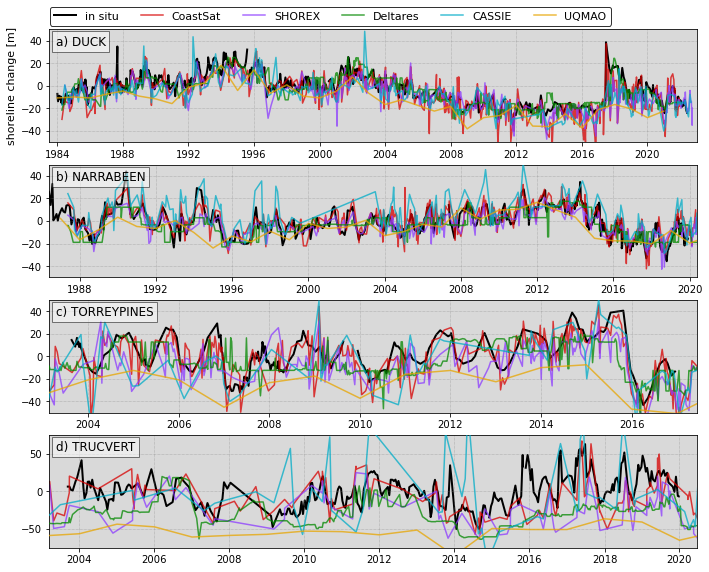

In [4]:
# selected transects (one per site) for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF8'],
    'DUCK':      ['1097'],
    'TRUCVERT':   ['-400',],
    'TORREYPINES':['PF525'],    
    }

# make figure
fig = plt.figure(figsize=[10,8], tight_layout=True)
gs = gridspec.GridSpec(4,1)
gs.update(left=0.08, right=0.98, bottom=0.05, top=0.95, hspace=0.2)
# loop through sites
for i,sitename in enumerate(names_datasets):
    key = selected_transects[sitename][0]
    gt = sub_output[groundtruth_type][sitename]
    
    ax = fig.add_subplot(gs[i,0])
    ax.grid(b=True,linestyle=':',lw=0.5,color='0.5',zorder=0)
    mean = np.nanmean(gt[key]['chainage'])
    
    # plot groundtruth
    ax.plot(gt[key]['dates'], gt[key]['chainage']-mean,'k-',lw=2,
            label='in situ',zorder=1)
    
    # loop through submissions
    for k,sub in enumerate(submissions):
        if key not in sub_output[sub][sitename].keys(): continue
        dates = sub_output[sub][sitename][key]['dates']
        chain = sub_output[sub][sitename][key]['chainage']
        # plot time-series
        ax.plot(dates, chain-mean, '-', lw=1.5, color=colours[k],
                alpha=0.75, label=sub.split('team_')[-1], zorder=1+k)
    # add label
    ax.text(0.01,0.95, letters[i] + ') ' + sitename, 
                bbox=dict(boxstyle="square", ec='k',fc='w',alpha=0.5), 
                ha='left',va='top', transform=ax.transAxes, fontsize=12,zorder=10)
    # ax.text(0.5,0.95, sitename, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
    #         va='top', transform=ax.transAxes, fontsize=12,zorder=10)
    # set axis limits
    ax.set_xlim([np.min(gt[key]['dates'])-timedelta(days=180),
                 np.max(gt[key]['dates'])+timedelta(days=180)])
    if sitename == 'NARRABEEN':
        ax.set_xlim([datetime(1986,6,1),
                     np.max(gt[key]['dates'])+timedelta(days=180)])
    ax.set_ylim(ylims)
    if sitename == 'TRUCVERT':
        ax.set_ylim(ylims*1.5)
    # add legend and ticks
    if i == 0: 
        ax.legend(ncol=6, fontsize=11, bbox_to_anchor=[0.875,1.25],
                  edgecolor='k');
        ax.set_ylabel('shoreline change [m]', fontsize=11)
    # if not i == len(names_datasets)-1:
    #     ax.set(xticklabels=[])
    ax.set_facecolor('0.85')
# save figure
fig.savefig(os.path.join(fp_eval_contour,'0_allsites_ts.jpg'),dpi=500)

#### 1.2. Plot the time-series for all the selected transects at each site 

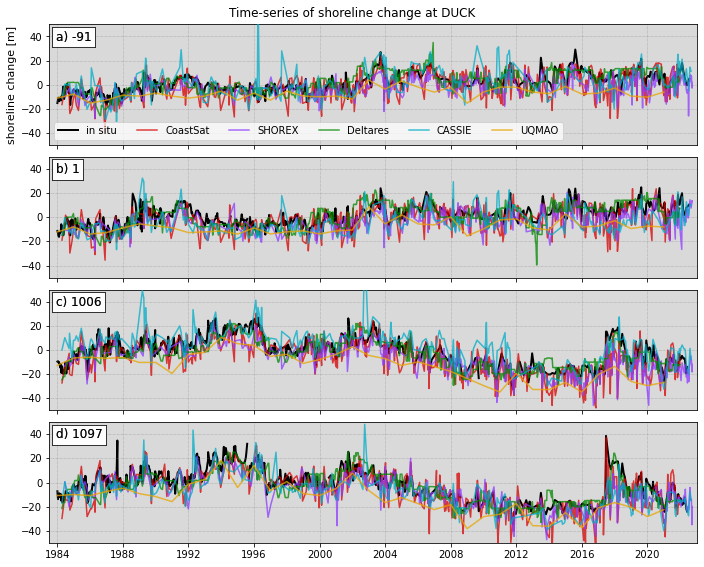

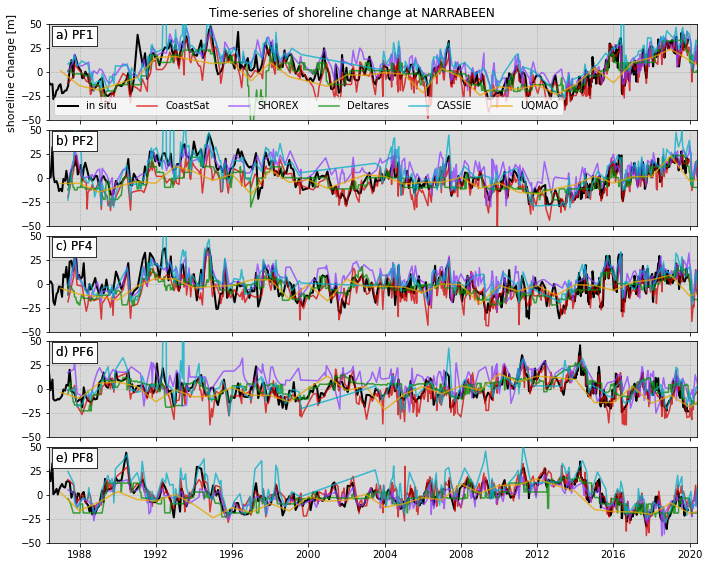

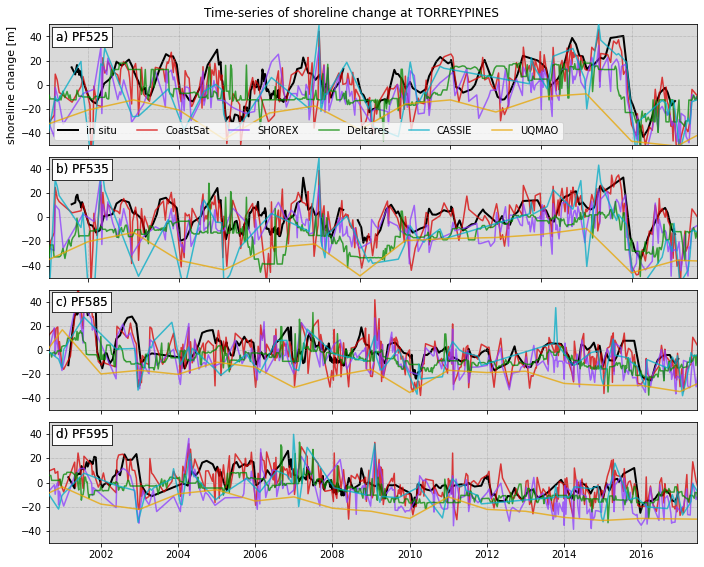

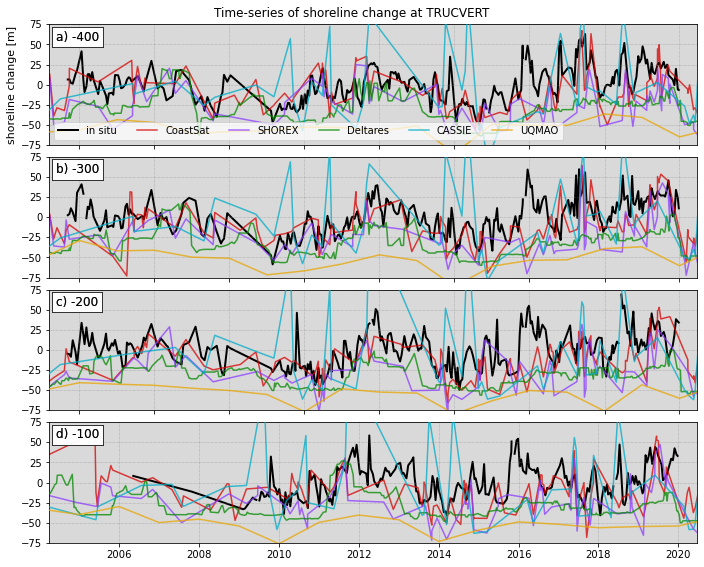

In [5]:
# selected transects for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],    
    }
# loop through sites
for sitename in names_datasets:
    transects = selected_transects[sitename]
    # make plot comparing the time-series
    fig = plt.figure(figsize=[10,8], tight_layout=True)
    fig.suptitle('Time-series of shoreline change at %s'%(sitename),fontsize=12)
    gs = gridspec.GridSpec(len(transects),1)
    gs.update(left=0.08, right=0.98, bottom=0.05, top=0.95, hspace=0.1)
    # load groundtruth
    gt = sub_output[groundtruth_type][sitename]
    # plot transects
    for i,key in enumerate(transects):
        ax = fig.add_subplot(gs[i,0])
        ax.grid(b=True,linestyle=':',lw=0.5,color='0.5',zorder=0)
        mean = np.nanmean(gt[key]['chainage'])
        # plot groundtruth
        ax.plot(gt[key]['dates'], gt[key]['chainage']-mean,'k-',lw=2,
                label='in situ',zorder=1)
        # loop through submissions
        for k,sub in enumerate(submissions):
            if key not in sub_output[sub][sitename].keys(): continue
            dates = sub_output[sub][sitename][key]['dates']
            chain = sub_output[sub][sitename][key]['chainage']
            # plot time-series
            ax.plot(dates, chain-mean, '-', lw=1.5, color=colours[k],
                    alpha=0.75, label=sub.split('team_')[-1], zorder=1+k)
            # add label
            tr_key = key
            if not 'PF' in key: tr_key = 'PF'+key
            ax.text(0.01,0.95, letters[i] + ') ' + key, 
                        bbox=dict(boxstyle="square", ec='k',fc='w',alpha=0.5), 
                        ha='left',va='top', transform=ax.transAxes, fontsize=12,zorder=10)
            # set axis limits
            ax.set_xlim([np.min(gt[key]['dates'])-timedelta(days=180),
                         np.max(gt[key]['dates'])+timedelta(days=180)])
            if sitename == 'NARRABEEN':
                ax.set_xlim([datetime(1986,6,1),
                             np.max(gt[key]['dates'])+timedelta(days=180)])
            ax.set_ylim(ylims)
            if sitename == 'TRUCVERT':
                ax.set_ylim(ylims*1.5)
            # add legend and ticks
            if i == 0: 
                ax.legend(loc='lower left',framealpha=0.75,ncol=6,fontsize=10) 
                ax.set_ylabel('shoreline change [m]', fontsize=11)
            if not i == len(transects)-1:
                ax.set(xticklabels=[])
            ax.set_facecolor('0.85')
    # save one figure per site
    fig.savefig(os.path.join(fp_eval_contour,'1_%s_ts.jpg'%sitename),dpi=200)

### 2. Assess the accuracy of the shoreline time-series 

In the next few sections, we calculate error metrics for each submission by comparing the time-series to the groundtruth.

The user can select the transects over which to evaluate the time-series and a few parameters for the assessment:
- `min_days`: 3 days (default), number of days over which it can be assumed that the shoreline has not change. If a survey is located within this time window, it is compared directly to the satellite shorelines.
- `max_days`: 10 days (default), number of days after which a comparison is not realistic any more due to shoreline changes. Between `min_days` and `max_days`, the surveyed shoreline time-series are interpolated to match the date of the satellite shoreline points.

There are also 2 visualisation parameters, the `binwidth` to use when plotting the histogram distributions and the limits (`lims`) over which to plot the errors.

#### 2.1. Compute horizontal errors and store in dictionary

A plot showing the comparison along each transect is stored under /evaluation/transects.

In [6]:
# parameters for evaluation
settings = {
    'min_days':  3,           # numbers of days difference under which to use nearest neighbour interpolation
    'max_days':  10,          # maximum number of days difference to do a comparison
    'binwidth':  3,           # binwidth for histogram plotting
    'lims':      [-50,50]     # cross-shore change limits for plotting purposes
           }

# selected transects for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],    
    }

# check if file exists
fn_errors = os.path.join(fp_eval_contour,'errors_%s.pkl'%contour)
if os.path.exists(fn_errors):
    # load output_eval pickle    
    with open(fn_errors,'rb') as f:
        output_eval = pickle.load(f)  
    print('Loaded errors dict...')    
else:
    # initialise dict
    output_eval = {}
    # loop through sites
    for sitename in names_datasets:
        output_eval[sitename] = {}
        # get selected transects
        transects = selected_transects[sitename]
        # get groundtruth
        gt = sub_output[groundtruth_type][sitename]
        # make plot comparing the time-series
        fig = plt.figure(figsize=[10,8], tight_layout=True)
        gs = gridspec.GridSpec(len(submissions),1)
        gs.update(left=0.08, right=0.98, bottom=0.05, top=0.95, hspace=0.1)
        # loop through submissions
        for k,sub in enumerate(submissions):
            fp_save = os.path.join(fp_eval_contour,'transects',sitename,sub)
            if not os.path.exists(fp_save): os.makedirs(fp_save)
            # evaluate the time-series along each transect
            chain_sat_all, chain_sur_all, satnames_all = [], [], []
            chain_sat_all_dm, chain_sur_all_dm = [], []
            for key in transects:
                if key not in sub_output[sub][sitename].keys(): continue
                if key not in gt.keys(): continue
                ts_sat, ts_sur, satnames, _ = utils.compare_timeseries2(sub_output[sub][sitename][key],gt,key,settings)
                _.savefig(os.path.join(fp_eval_contour,'transects',sitename,sub,'%s.jpg'%key))
                plt.close(_)
                chain_sat_all = np.append(chain_sat_all,ts_sat)
                chain_sur_all = np.append(chain_sur_all,ts_sur)
                satnames_all = satnames_all + satnames
                # add demeaned time-series for calculating R2
                chain_sat_all_dm = np.append(chain_sat_all_dm,ts_sat-np.nanmean(ts_sat))
                chain_sur_all_dm = np.append(chain_sur_all_dm,ts_sur-np.nanmean(ts_sur))
            
            # store matching points in dict
            output_eval[sitename][sub] = {'chain_sat':chain_sat_all,
                                          'chain_gt':chain_sur_all,
                                          'satnames':satnames_all,
                                          'chain_sat_dm':chain_sat_all_dm,
                                          'chain_gt_dm':chain_sur_all_dm}
            
            # calculate statistics for site
            chain_error = chain_sat_all - chain_sur_all
            slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur_all_dm, chain_sat_all_dm)
            R2 = rvalue**2
            rmse = np.sqrt(np.mean((chain_error)**2))
            mean = np.mean(chain_error)
            std = np.std(chain_error)
            q90 = np.percentile(np.abs(chain_error), 90)
            
            # store in dict
            output_eval[sitename][sub]['R2'] = R2
            output_eval[sitename][sub]['RMSE'] = rmse
            output_eval[sitename][sub]['Mean'] = mean
            output_eval[sitename][sub]['STD'] = std
            output_eval[sitename][sub]['q90'] = q90
    
    # save output_eval as pickle    
    with open(fn_errors,'wb') as f:
        pickle.dump(output_eval,f)
    print('Generated errors dict...')   

Generated errors dict...


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

#### 2.2. Plot histograms of error distributions for each site and each algorithm

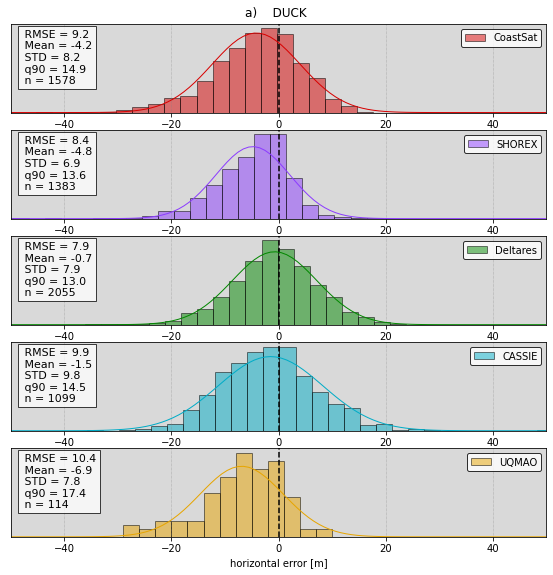

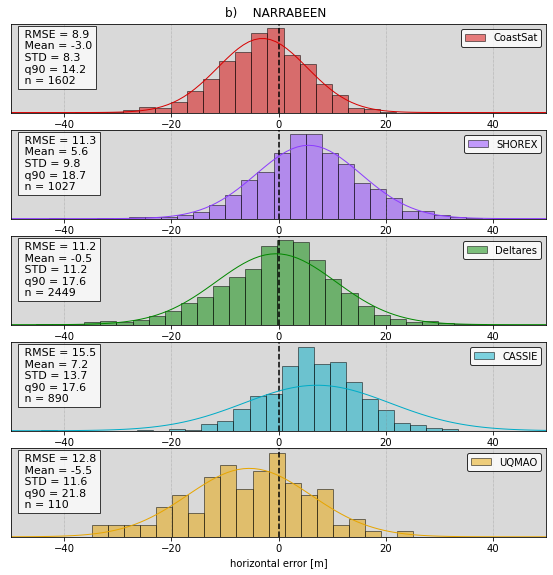

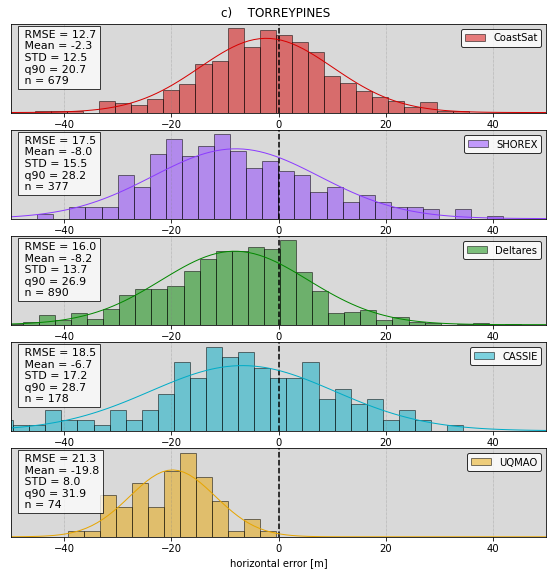

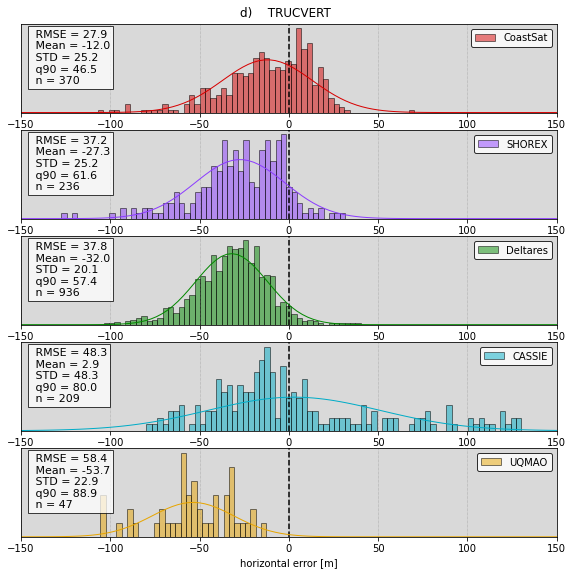

In [7]:
# loop through sites
for i,sitename in enumerate(names_datasets):
    # make plot comparing the time-series
    fig = plt.figure(figsize=[8,8], tight_layout=True)
    gs = gridspec.GridSpec(len(submissions),1)
    gs.update(left=0.04, right=0.97, bottom=0.06, top=0.95, hspace=0.2)
    fig.suptitle('%s)    %s'%(letters[i],sitename),fontsize=12)
    if sitename == 'TRUCVERT': 
        xlims = [-150,150]
        binwidth = 10
    else:
        xlims = settings['lims']
        binwidth = settings['binwidth']

    # loop through submissions
    for k,sub in enumerate(submissions):
        chain_error = output_eval[sitename][sub]['chain_sat'] - output_eval[sitename][sub]['chain_gt']
        # get metrics
        R2 = output_eval[sitename][sub]['R2']
        rmse = output_eval[sitename][sub]['RMSE']
        mean = output_eval[sitename][sub]['Mean']
        std = output_eval[sitename][sub]['STD']
        q90 = output_eval[sitename][sub]['q90']
        
        # plot histogram
        ax = fig.add_subplot(gs[k,0])
        ax.grid(b=True,linestyle=':',lw=0.5,color='0.5',zorder=0) 
        ax.axvline(x=0, ls='--', lw=1.5, color='k')
        binwidth = settings['binwidth']
        bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
        density = ax.hist(chain_error, bins=bins, density=True, color=colours[k],
                          edgecolor='k', alpha=0.5, label=sub.split('team_')[-1])
        mu, std = stats.norm.fit(chain_error)
        pval = stats.normaltest(chain_error)[1]
        x = np.linspace(xlims[0], xlims[1], 100)
        p = stats.norm.pdf(x, mu, std)
        ax.plot(x, p, '-',color=colours[k], linewidth=1)
        ax.set(xlabel='horizontal error [m]', xlim=xlims)
        str_stats = ' RMSE = %.1f\n Mean = %.1f\n STD = %.1f\n q90 = %.1f\n n = %d' % (rmse, mean, std, q90, len(chain_error))
        ax.text(0.02, 0.94, str_stats,va='top', transform=ax.transAxes,fontsize=11,
                bbox=dict(boxstyle="square", ec='k',fc='w',alpha=0.75))
        ax.legend(loc='upper right',edgecolor='k')
        ax.set_yticks([])
        ax.set_facecolor('0.85')
    fig.savefig(os.path.join(fp_eval_contour,'2_%s_histograms.jpg'%sitename),dpi=200)

#### 2.3. Make a summary boxplot with all the results for each algorithm and site 

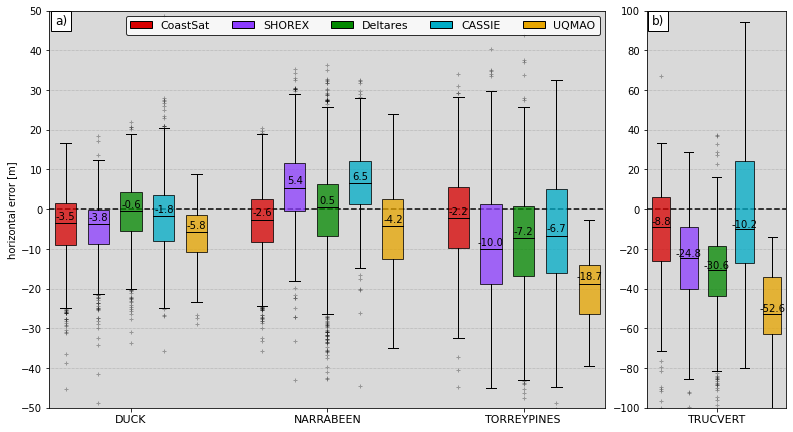

In [8]:
factor = 6
# make plot comparing the time-series
fig = plt.figure(figsize=[11.5,6.2], tight_layout=True)
gs = gridspec.GridSpec(1,2,width_ratios=[4,1])
gs.update(left=0.08, right=0.97, bottom=0.06, top=0.95, wspace=0.12)
# axis 1 for DUCK, NARRABEEN, TORREYPINES
ax1 = fig.add_subplot(gs[0])
ax1.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax1.set_facecolor('0.85')
ax1.axhline(y=0, ls='--', lw=1.5, color='k')
ax1.set(ylabel='horizontal error [m]', ylim=[-50,50]);
# axis 2 for TRUCVERT (different y-scale)
ax2 = fig.add_subplot(gs[1])
ax2.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax2.set_facecolor('0.85')
ax2.axhline(y=0, ls='--', lw=1.5, color='k')
ax2.set(ylim=[-100,100])
submissions_short = [_.split('team_')[-1] for _ in submissions]
# loop through sites
for i,sitename in enumerate(names_datasets):
    # loop through submissions
    for k,sub in enumerate(submissions): 
        # plot TRUCVERT on its onw axis as the errors are much larger
        if sitename == 'TRUCVERT': ax = ax2
        else: ax = ax1
        # compute errors
        chain_error = output_eval[sitename][sub]['chain_sat'] - output_eval[sitename][sub]['chain_gt']
        # plot boxplot
        bp = ax.boxplot(chain_error,sym='+',positions=[(i)*factor+k],
                        widths=0.65,patch_artist=True,showfliers=True,
                        whiskerprops={'linewidth':1},
                        flierprops={'alpha':0.3,'markersize':4,
                                    'color':'0.5'})
        for median in bp['medians']:
            median.set(color='k', linewidth=1)
        for j,boxes in enumerate(bp['boxes']):
            boxes.set(facecolor=colours[k],alpha=0.75)
        # add median value as text
        ax.text((i)*factor+k,np.median(chain_error)+1,
                '%.1f'%np.median(chain_error),
                horizontalalignment='center', fontsize=10)
# add legend
handles = []
for k,sub in enumerate(submissions):
    handles.append(mpatches.Patch(color=colours[k],ec='k',label=submissions_short[k]))
ax1.legend(handles=handles, loc='upper right', ncol=5, fontsize=11,edgecolor='k',);
# set xticklabels
ax1.set_xticks([(_)*factor+factor/2-1 for _ in range(0,len(names_datasets)-1)],labels=names_datasets[:-1]);
ax1.set_xticklabels(names_datasets[:-1],fontweight='normal',fontsize=11);
ax2.set_xticks([(_)*factor+factor/2-1 for _ in [3]],labels=[names_datasets[-1]]);
ax2.set_xticklabels([names_datasets[-1]],fontweight='normal',fontsize=11);
# set yticklabels
ax1.set_yticks(np.arange(-50,50+10,10));
ax2.set_yticks(np.arange(-100,100+20,20));
# add letters
ax1.text(0.01,0.99, letters[0] + ')', 
         bbox=dict(boxstyle="square", ec='k',fc='w',alpha=1), 
         ha='left',va='top', transform=ax1.transAxes, fontsize=12,zorder=10)
ax2.text(0.035,0.99, letters[1] + ')', 
         bbox=dict(boxstyle="square", ec='k',fc='w',alpha=1), 
         ha='left',va='top', transform=ax2.transAxes, fontsize=12,zorder=10)
# save figure
fig.savefig(os.path.join(fp_eval_contour,'3_boxplots_selected.jpg'),dpi=500)

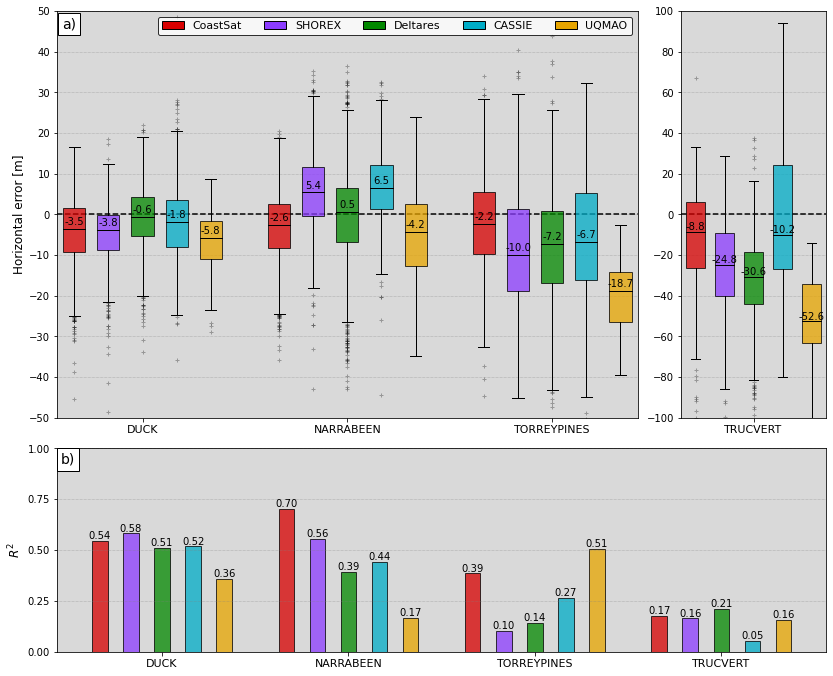

In [9]:
#%% Combine boxplot and R2

factor = 6
# make plot comparing the time-series
fig = plt.figure(figsize=[12,10], tight_layout=True)
gs = gridspec.GridSpec(2,2,width_ratios=[4,1],height_ratios=[2,1])
gs.update(left=0.08, right=0.97, bottom=0.06, top=0.95, wspace=0.12, hspace=0.1)
# axis 1 for DUCK, NARRABEEN, TORREYPINES
ax1 = fig.add_subplot(gs[0,0])
ax1.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax1.set_facecolor('0.85')
ax1.axhline(y=0, ls='--', lw=1.5, color='k')
ax1.set(ylim=[-50,50]);
ax1.set_ylabel('Horizontal error [m]',fontsize=12)
# axis 2 for TRUCVERT (different y-scale)
ax2 = fig.add_subplot(gs[0,1])
ax2.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax2.set_facecolor('0.85')
ax2.axhline(y=0, ls='--', lw=1.5, color='k')
ax2.set(ylim=[-100,100])
submissions_short = [_.split('team_')[-1] for _ in submissions]
# loop through sites
for i,sitename in enumerate(names_datasets):
    # loop through submissions
    for k,sub in enumerate(submissions): 
        # plot TRUCVERT on its onw axis as the errors are much larger
        if sitename == 'TRUCVERT': ax = ax2
        else: ax = ax1
        # compute errors
        chain_error = output_eval[sitename][sub]['chain_sat'] - output_eval[sitename][sub]['chain_gt']
        # plot boxplot
        bp = ax.boxplot(chain_error,sym='+',positions=[(i)*factor+k],
                        widths=0.65,patch_artist=True,showfliers=True,
                        whiskerprops={'linewidth':1},
                        flierprops={'alpha':0.3,'markersize':4,
                                    'color':'0.5'})
        for median in bp['medians']:
            median.set(color='k', linewidth=1)
        for j,boxes in enumerate(bp['boxes']):
            boxes.set(facecolor=colours[k],alpha=0.75)
        # add median value as text
        ax.text((i)*factor+k,np.median(chain_error)+1,
                '%.1f'%np.median(chain_error),
                horizontalalignment='center', fontsize=10)
# add legend
handles = []
for k,sub in enumerate(submissions):
    handles.append(mpatches.Patch(color=colours[k],ec='k',label=submissions_short[k]))
ax1.legend(handles=handles, loc='upper right', ncol=5, fontsize=11,edgecolor='k',);
# set xticklabels
ax1.set_xticks([(_)*factor+factor/2-1 for _ in range(0,len(names_datasets)-1)],labels=names_datasets[:-1]);
ax1.set_xticklabels(names_datasets[:-1],fontweight='normal',fontsize=11);
ax2.set_xticks([(_)*factor+factor/2-1 for _ in [3]],labels=[names_datasets[-1]]);
ax2.set_xticklabels([names_datasets[-1]],fontweight='normal',fontsize=11);
# set yticklabels
ax1.set_yticks(np.arange(-50,50+10,10));
ax2.set_yticks(np.arange(-100,100+20,20));
# add letters
ax1.text(0.008,0.985, letters[0] + ')', 
         bbox=dict(boxstyle="square", ec='k',fc='w',alpha=1), 
         ha='left',va='top', transform=ax1.transAxes, fontsize=14,zorder=10)

ax3 = fig.add_subplot(gs[1,:])
ax3.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
ax3.set_facecolor('0.85')
ax3.set( ylim=[0,1]);
ax3.set_ylabel(r'$R^2$',fontsize=12)
ax3.text(0.005,0.98, letters[1] + ')', 
         bbox=dict(boxstyle="square", ec='k',fc='w',alpha=1), 
         ha='left',va='top', transform=ax3.transAxes, fontsize=14,zorder=10)
# loop through sites
for i,sitename in enumerate(names_datasets):
    # loop through submissions
    for k,sub in enumerate(submissions): 
        # plot TRUCVERT on its onw axis as the errors are much larger
        # compute errors
        ax3.bar((i)*factor+k,output_eval[sitename][sub]['R2'],ec='k',fc=colours[k],width=0.5,alpha=0.75)
        # add median value as text
        ax3.text((i)*factor+k,output_eval[sitename][sub]['R2']+0.01,
                '%.2f'%output_eval[sitename][sub]['R2'],
                horizontalalignment='center', fontsize=10)
# set xticklabels
ax3.set_xticks([(_)*factor+factor/2-1 for _ in range(0,len(names_datasets))],labels=names_datasets);
ax3.set_xticklabels(names_datasets,fontweight='normal',fontsize=11);
# set yticklabels
ax3.set_yticks(np.arange(0,1+0.25,0.25));
fig.savefig(os.path.join(fp_eval_contour,'3_R2_selected.jpg'),dpi=500)

### 3. Evaluate the long-term linear trends

Here we evaluate the accuracy of the long-term linear trends extracted from the SDS time-series compared to the trend indicated by the groundtruth time-series over the same period of time.

#### 3.1. Calculate linear trends for common period of time using seasonally-averaged time-series

Note that we use seasonally-averaged shoreline time-series to make the temporal resolution more uniform. As there are more satellite images towards the end of the record, using the raw time-series may introduce a bias.

Loaded formatted dict...
Removed S2 from SHOREX
['team_CoastSat', 'team_SHOREX', 'team_Deltares', 'team_CASSIE', 'team_UQMAO']
Generated trends.pkl dict...


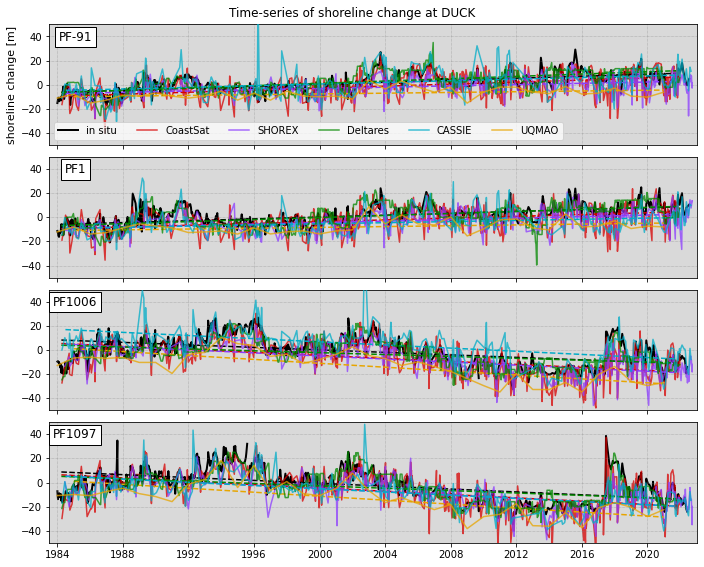

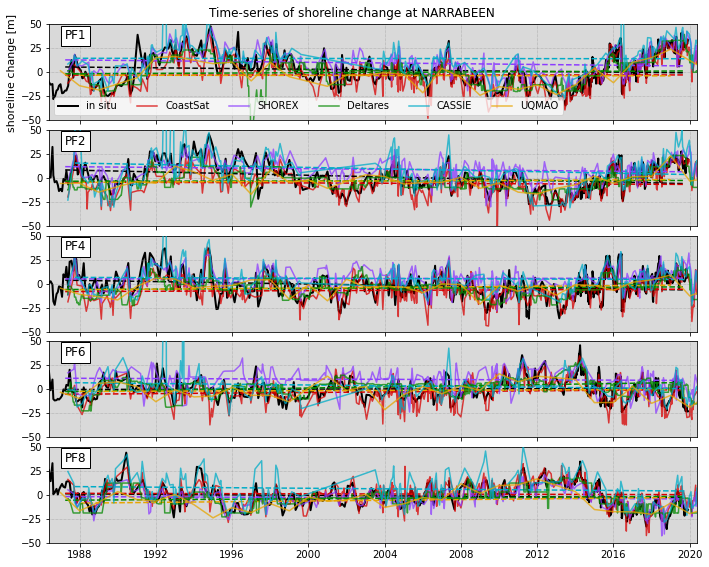

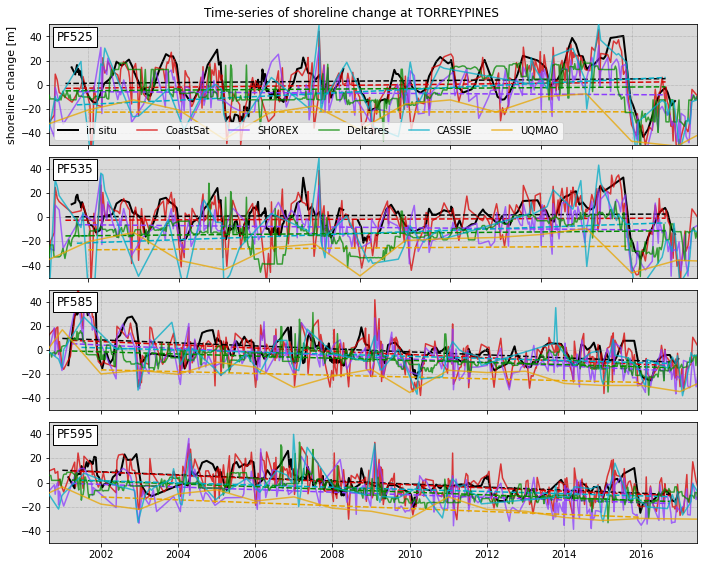

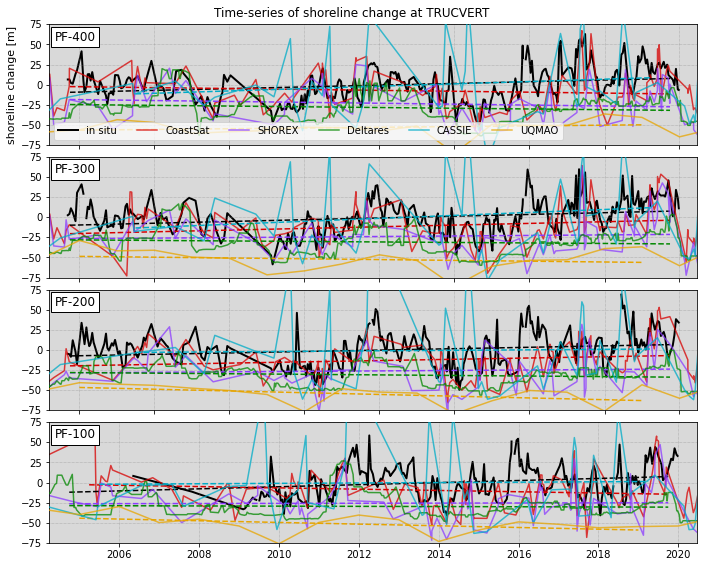

In [10]:
# load submitted shoreline time-series (already preprocessed above)
contour = 'MSL'
groundtruth_type = 'groundtruth_%s'%contour

# folder to store evaluation outputs
fp_eval_contour =  os.path.join(fp_eval,contour)
if not os.path.exists(fp_eval_contour): os.makedirs(fp_eval_contour)
fp_trends = os.path.join(fp_eval_contour,'trends')
if not os.path.exists(fp_trends): os.makedirs(fp_trends)

# check if file already exists
fn_output = os.path.join(fp_eval_contour,'submissions_%s.pkl'%contour)
if os.path.exists(fn_output):
    # load submissions
    with open(fn_output,'rb') as f:
        sub_output = pickle.load(f)    
    print('Loaded formatted dict...')
          
# remove S2 shorelines from SHOREX
for sitename in sub_output['team_SHOREX'].keys():
    for transect in sub_output['team_SHOREX'][sitename].keys():
        satname = sub_output['team_SHOREX'][sitename][transect]['satname']
        idx_noS2 = [not _ == 'S2' for _ in satname]
        sub_output['team_SHOREX'][sitename][transect]['chainage'] = sub_output['team_SHOREX'][sitename][transect]['chainage'][idx_noS2]
        sub_output['team_SHOREX'][sitename][transect]['dates'] = [sub_output['team_SHOREX'][sitename][transect]['dates'][_] for _ in np.where(idx_noS2)[0]]
        sub_output['team_SHOREX'][sitename][transect]['satname'] = [sub_output['team_SHOREX'][sitename][transect]['satname'][_] for _ in np.where(idx_noS2)[0]]
print('Removed S2 from SHOREX')

# filepath to submissions
fp_submissions = os.path.join(os.path.join(os.getcwd(),'submissions'))
submissions = [_ for _ in os.listdir(fp_submissions) if _ not in ['README.md','example_submission']]
submissions = [submissions[_] for _ in [1,3,2,0,4]]
print(submissions)

# initialise dictionnary where to store the calculated trends
trends_output = {}
# selected transects for comparison with groundtruth
selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],    
    }
# colorpalette to use for each submission
cmap = get_cmap("cet_glasbey_dark")
colours = cmap(np.arange(10))
# limits of yaxis in shoreline plots
ylims = np.array([-50,50])
# loop through sites
for sitename in names_datasets:
    trends_output[sitename] = {}
    transects = selected_transects[sitename]
    # make plot comparing the time-series
    fig = plt.figure(figsize=[10,8], tight_layout=True)
    fig.suptitle('Time-series of shoreline change at %s'%(sitename),fontsize=12)
    gs = gridspec.GridSpec(len(transects),1)
    gs.update(left=0.08, right=0.98, bottom=0.05, top=0.95, hspace=0.1)
    # load groundtruth
    gt = sub_output[groundtruth_type][sitename]
    # plot transects
    for i,key in enumerate(transects):
        trends_output[sitename][key] = {}
        ax = fig.add_subplot(gs[i,0])
        ax.grid(b=True,linestyle=':',lw=0.5,color='0.5',zorder=0)
        mean = np.nanmean(gt[key]['chainage'])
        # plot groundtruth
        ax.plot(gt[key]['dates'], gt[key]['chainage']-mean,'k-',lw=2,
                label='in situ',zorder=1)
        
        # clip groundtruth and satellite shorelines to match
        date_start_sat = sub_output['team_CoastSat'][sitename][key]['dates'][0]
        date_end_sat = sub_output['team_CoastSat'][sitename][key]['dates'][-1]
        date_start_sur = gt[key]['dates'][0]
        date_end_sur = gt[key]['dates'][-1]
        date_start = np.max([date_start_sat,date_start_sur])
        date_end = np.min([date_end_sat,date_end_sur])
        idx_gt = []
        for _,date in enumerate(gt[key]['dates']):
            if (date >= date_start) and (date <= date_end):
                idx_gt.append(_)
        dates_sur = [gt[key]['dates'][_] for _ in idx_gt]
        if 'chainage' in gt[key].keys():
            chain_str = 'chainage'
        elif 'chainages' in gt[key].keys():
            chain_str = 'chainages'
        chain_sur = np.array([float(_) for _ in gt[key][chain_str]])
        chain_sur = chain_sur[np.array(idx_gt)]
        # remove nans
        idx_nan = np.isnan(chain_sur)
        dates_sur = [dates_sur[_] for _ in np.where(~idx_nan)[0]]
        chain_sur = chain_sur[~idx_nan]
        # compute trend on seasonally-averaged time-series
        dict_seas, dates_seas, chainage_seas, list_seas = utils.seasonal_average(dates_sur, chain_sur)
        dates_ord = np.array([_.toordinal() for _ in dates_seas])
        dates_ord = (dates_ord - np.min(dates_ord))/365.2425   
        trend, intercept, rvalue, pvalue, std_err = stats.linregress(dates_ord, chainage_seas)
        trends_output[sitename][key]['gt'] = trend
        x = [dates_seas[0],dates_seas[-1]]
        y = np.array([np.min(dates_ord),np.max(dates_ord)-np.min(dates_ord)])*trend+intercept-mean
        ax.plot(x,y,'--',color='k')

        # loop through submissions
        for k,sub in enumerate(submissions):
            if key not in sub_output[sub][sitename].keys(): continue
            dates = sub_output[sub][sitename][key]['dates']
            chain = sub_output[sub][sitename][key]['chainage']
            # plot time-series
            ax.plot(dates, chain-mean, '-', lw=1.5, color=colours[k],
                    alpha=0.75, label=sub.split('team_')[-1], zorder=1+k)
            # remove nans
            idx_nan = np.isnan(chain)
            dates = [dates[_] for _ in np.where(~idx_nan)[0]]
            chain = chain[~idx_nan]
            # clip to dates 
            idx_sat = []
            for _,date in enumerate(dates):
                if (date >= date_start) and (date <= date_end):
                    idx_sat.append(_)
            dates = [dates[_] for _ in idx_sat]
            chain = chain[np.array(idx_sat)]            
            
            # compute shoreline monthly averages
            dict_seas, dates_seas, chainage_seas, list_seas = utils.seasonal_average(dates, chain)
            # ax.plot(dates_seas,chainage_seas-mean,'b-')
            
            # compute trend on seasonally-averaged time-series
            dates_ord = np.array([_.toordinal() for _ in dates_seas])
            dates_ord = (dates_ord - np.min(dates_ord))/365.2425   
            trend, intercept, rvalue, pvalue, std_err = stats.linregress(dates_ord, chainage_seas)
            trends_output[sitename][key][sub] = trend
            
            # plot trend
            x = [dates_seas[0],dates_seas[-1]]
            y = np.array([np.min(dates_ord),np.max(dates_ord)-np.min(dates_ord)])*trend+intercept-mean
            ax.plot(x,y,'--',color=colours[k])
            
        # add label
        tr_key = key
        if not 'PF' in key: tr_key = 'PF'+key
        ax.text(0.04,0.95, tr_key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
                va='top', transform=ax.transAxes, fontsize=12,zorder=10) 
        # set axis limits
        ax.set_xlim([np.min(gt[key]['dates'])-timedelta(days=180),
                     np.max(gt[key]['dates'])+timedelta(days=180)])
        if sitename == 'NARRABEEN':
            ax.set_xlim([datetime(1986,6,1),
                         np.max(gt[key]['dates'])+timedelta(days=180)])
        ax.set_ylim(ylims)
        if sitename == 'TRUCVERT':
            ax.set_ylim(ylims*1.5)
        # add legend and ticks
        if i == 0: 
            ax.legend(loc='lower left',framealpha=0.75,ncol=6,fontsize=10) 
            ax.set_ylabel('shoreline change [m]', fontsize=11)
        if not i == len(transects)-1:
            ax.set(xticklabels=[])
        ax.set_facecolor('0.85')
            
    # save one figure per site
    fig.savefig(os.path.join(fp_trends,'4_trends_%s.jpg'%sitename),dpi=200)

# save output
fn_output = os.path.join(fp_trends,'trends.pkl')
with open(fn_output,'wb') as f:
    pickle.dump(trends_output,f) 
print('Generated trends.pkl dict...')


#### 3.2. Assess accuracy in estimating long-term trends

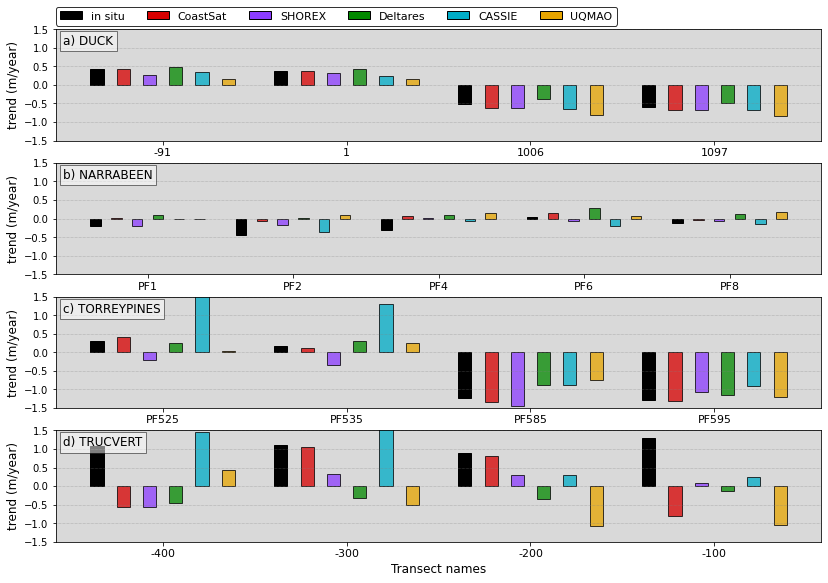

In [11]:
fn_output = os.path.join(fp_trends,'trends.pkl')
with open(fn_output,'rb') as f:
    trends_output = pickle.load(f)

selected_transects = {
    'NARRABEEN': ['PF1','PF2','PF4','PF6','PF8'],
    'DUCK':      ['-91','1','1006','1097'],
    'TRUCVERT':   ['-400','-300','-200','-100'],
    'TORREYPINES':['PF525','PF535','PF585','PF595'],    
    }

factor = 7
fig = plt.figure(figsize=[11.5,8], tight_layout=True)
gs = gridspec.GridSpec(4,1)
gs.update(left=0.065, right=0.99, bottom=0.06, top=0.95, wspace=0.12)
axs = []
letters = string.ascii_lowercase
for i in range(4):
    ax = fig.add_subplot(gs[i])
    axs.append(ax)
    ax.grid(b=True,axis='y',linestyle=':',lw=0.5,color='0.5',zorder=0) 
    ax.set_facecolor('0.85')  
    ax.set(ylim=[-1.5,1.5])
    ax.set_ylabel('trend (m/year)', fontsize=12)
# loop through sites
for i,sitename in enumerate(names_datasets):
    axs[i].text(0.01,0.95, letters[i] + ') ' + sitename, 
                bbox=dict(boxstyle="square", ec='k',fc='w',alpha=0.5), 
                ha='left',va='top', transform=axs[i].transAxes, fontsize=12,zorder=10)
    for l,key in enumerate(selected_transects[sitename]):
        # plot groundtruth
        axs[i].bar((l)*factor,trends_output[sitename][key]['gt'],ec='k',fc='k',width=0.5)
        # loop through submissions
        for k,sub in enumerate(submissions):
            axs[i].bar((l)*factor+k+1,trends_output[sitename][key][sub],ec='k',fc=colours[k],alpha=0.75,width=0.5)
    # set xticklabels
    axs[i].set_xticks([(_)*factor+factor/2-1 for _ in range(0,len(selected_transects[sitename]))],labels=selected_transects[sitename]);
    axs[i].set_xticklabels(selected_transects[sitename],fontweight='normal',fontsize=11);
    axs[i].set_yticks(np.arange(-1.5,2,0.5));

submissions_short = [_.split('team_')[-1] for _ in submissions]
# add legend
handles = []
handles.append(mpatches.Patch(color='k',ec='k',label='in situ'))
for k,sub in enumerate(submissions):
    handles.append(mpatches.Patch(color=colours[k],ec='k',label=submissions_short[k]))
axs[0].legend(handles=handles, ncol=6, fontsize=11, bbox_to_anchor=[0.74,1.25],
              edgecolor='k');
axs[-1].set_xlabel('Transect names',fontsize=12)
# save figure
fig.savefig(os.path.join(fp_trends,'4_summary_of_trends.jpg'),dpi=500)